<a href="https://colab.research.google.com/github/TeaFromHand/credit-default-prediction/blob/main/Credit_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Scoring with Taiwan Dataset**

#Step 1: Data collection

In [1]:
!pip install scikit-learn opendatasets


In [2]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
%matplotlib inline
import sklearn
import opendatasets as od
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE

In [3]:
#Import datah
od.download("https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data?select=UCI_Credit_Card.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: g
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset


100%|██████████| 0.98M/0.98M [00:00<00:00, 175MB/s]

# Step 2: Understand the Data and Problem

In [4]:
df = pd.read_csv('/content/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [7]:
df.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [8]:
df.isnull().sum()

,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


# Step 3: Data Preprocessing

## 3.1 Extra value processing

There were some values that didn't have real values like 0, 4, 5, 6 in EDUCATION, I will convert all of it into 4, and the same with MARRIAGE

In [9]:
#Data cleaning
#Convert all null value into 1 value
df['MARRIAGE'].replace(0,3,inplace=True)
df['EDUCATION'].replace([0,5,6],4,inplace=True)


ID is an excessive variable

In [10]:
#Drop ID column
df.drop('ID', axis=1, inplace=True)

## 3.2 Split train test set

Train - test
80 - 20

In [11]:
#Spit train test set
X = df.drop(['default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

# Perform train test split on the original features
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

##3.3 Features Engineering

In [12]:
#Feature Engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
      def __init__(self):
        #Collect all variables having common points in new variables
          self.pay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
          self.bill_amt_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
          self.pay_amt_cols = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

      def fit(self, X, y=None):
          return self

      def transform(self, X):
          X_new = X.copy() #Create a new copy of X set

          #Ensure that all numeric columns are numerical
          for col in self.bill_amt_cols + self.pay_amt_cols + self.pay_cols:
            X_new[col] = pd.to_numeric(X_new[col], errors='coerce')

          #Create new features
          #1 Serious delinquency count:
          X_new['SERIOUS_DELINQ_COUNT'] = (X_new[self.pay_cols]>=2).sum(axis=1)

          #2 Zero pay count;
          X_new['ZERO PAY COUNT'] = (X_new[self.pay_cols] == 0).sum(axis=1)

          #3 Average utilization ratio:
          util_ratios = []
          for col in (self.bill_amt_cols):
              util_ratios.append(X_new[col] / (X_new['LIMIT_BAL'] + 1)) #Prevent /0 case
          X_new['AVG_UTIL_RATIO'] = pd.concat(util_ratios, axis=1).mean(axis=1)

          #4 Average payment ratio:
          payment_ratios = []
          for bill, pay in zip(self.bill_amt_cols, self.pay_amt_cols):
            ratio = X_new[pay] / X_new[bill].replace(0, np.nan) #Replace 0 = NaN to prevent /0
            ratio = ratio.fillna(1) #Consider bill = 0 then ratio = 1
            ratio = ratio.clip(upper=10) #Limit to 10 to prevent outliers
            payment_ratios.append(ratio)
          X_new['AVG_PAYMENT_RATIO'] = pd.concat(payment_ratios, axis=1).mean(axis=1)

          #5 Average bill trend:
          bill_diff = []
          for i in range (5):
            bill_diff.append(X_new[self.bill_amt_cols[i]] - X_new[self.bill_amt_cols[i+1]]) #Bill this month - bill previous month
          X_new['AVG_BILL_TREND'] = pd.concat(bill_diff, axis=1).mean(axis=1)

          #6 Bill fluctuation:
          X_new['BILL_FLUC'] = X_new[self.bill_amt_cols].std(axis=1, ddof=0) #Standard deviation of bill_amt columns

          return X_new

###3.3.1 Summary Table of Predictive Feature Significance

| Variable Name | Data Source | Formula/Calculation | Risk Implication |
| :--- | :--- | :--- | :--- |
| **SERIOUS_DELINQ_COUNT** | PAY_0 to PAY_6 | Count of times $PAY_x \ge 2$ (Overdue $\ge 2$ months). | **Highest:** Customer has poor repayment habits; default risk is very high. |
| **ZERO_PAY_COUNT** | PAY_0 to PAY_6 | Count of times $PAY_x = 0$ (Minimum payment/Revolving). | **High:** Customer relies on revolving credit; a sign of financial distress. |
| **AVER_UTIL_RATIO** | BILL_AMT / LIMIT_BAL | Average of $\frac{\text{Outstanding Balance}}{\text{Limit}}$ over 6 months. | **High:** Credit limit is near exhaustion; customer is under financial strain. |
| **AVG_PAYMENT_RATIO** | PAY_AMT / BILL_AMT | Average monthly ratio of $\frac{\text{Paid Amount}}{\text{Billed Amount}}$. | **Low:** Customer is only paying the minimum amount. |
| **AVG_BILL_TREND** | BILL_AMT$_n$ - BILL_AMT$_{n+1}$ | Average difference between current month's and previous month's bill. | **Positive:** Outstanding balance is trending upward; risk is increasing. |
| **BILL_FLUC** | $\text{STD}(\text{BILL_AMT$_{1...6}$})$ | Standard deviation of outstanding balance over 6 months. | **High:** Unstable spending behavior; difficult to predict. |

## 3.4 Data Transformation

In [13]:
X_new = FeatureEngineer().transform(X_train)
X_new.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SERIOUS_DELINQ_COUNT,ZERO PAY COUNT,AVG_UTIL_RATIO,AVG_PAYMENT_RATIO,AVG_BILL_TREND,BILL_FLUC
22788,160000.0,2,2,2,33,2,2,3,2,0,...,0.0,6100.0,12300.0,6100.0,4,2,1.034306,0.040480,-246.8,3864.492895
29006,150000.0,2,1,2,34,1,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,0,0,0.000059,0.833333,0.0,19.751934
16950,10000.0,1,2,1,50,1,2,0,0,0,...,1134.0,294.0,305.0,1000.0,1,4,0.857598,0.080701,354.2,725.058024
22280,220000.0,2,1,2,29,0,0,0,0,0,...,7887.0,4800.0,4900.0,6000.0,0,6,0.846643,0.037856,14506.6,37836.311711
11346,310000.0,2,1,2,32,1,-2,-1,0,0,...,0.0,0.0,0.0,1200.0,0,2,0.000098,-0.517730,47.0,230.029467


In [14]:
fe = FeatureEngineer()
X_train_engineered = fe.fit_transform(X_train)

#Create df_features from train data
df_features = X_train_engineered[['SERIOUS_DELINQ_COUNT', 'ZERO PAY COUNT',
                                   'AVG_UTIL_RATIO', 'AVG_PAYMENT_RATIO',
                                   'AVG_BILL_TREND', 'BILL_FLUC']].copy()
df_features['default'] = y_train.values

# Step 4: EDA with Visualization

## 4.1 Visualization

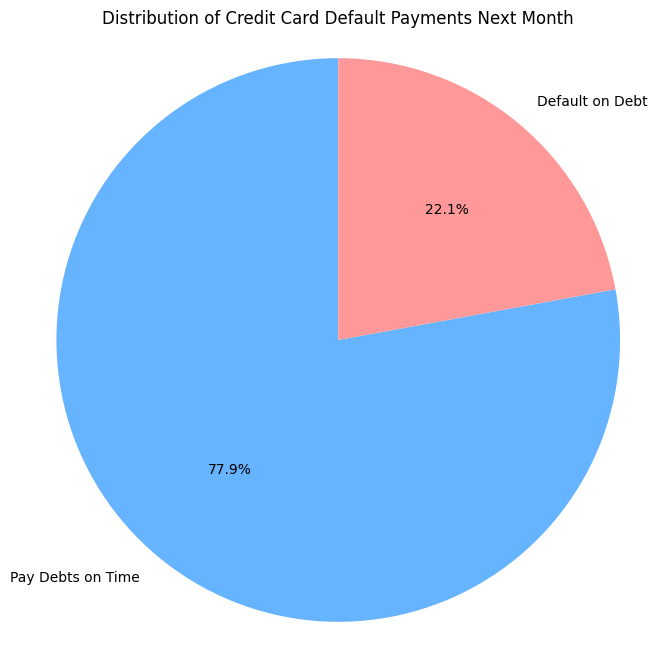

In [15]:
default_counts = y_train.value_counts()
default_labels = ['Pay Debts on Time', 'Default on Debt']

plt.figure(figsize=(8, 8))
plt.pie(default_counts, labels=default_labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Credit Card Default Payments Next Month')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

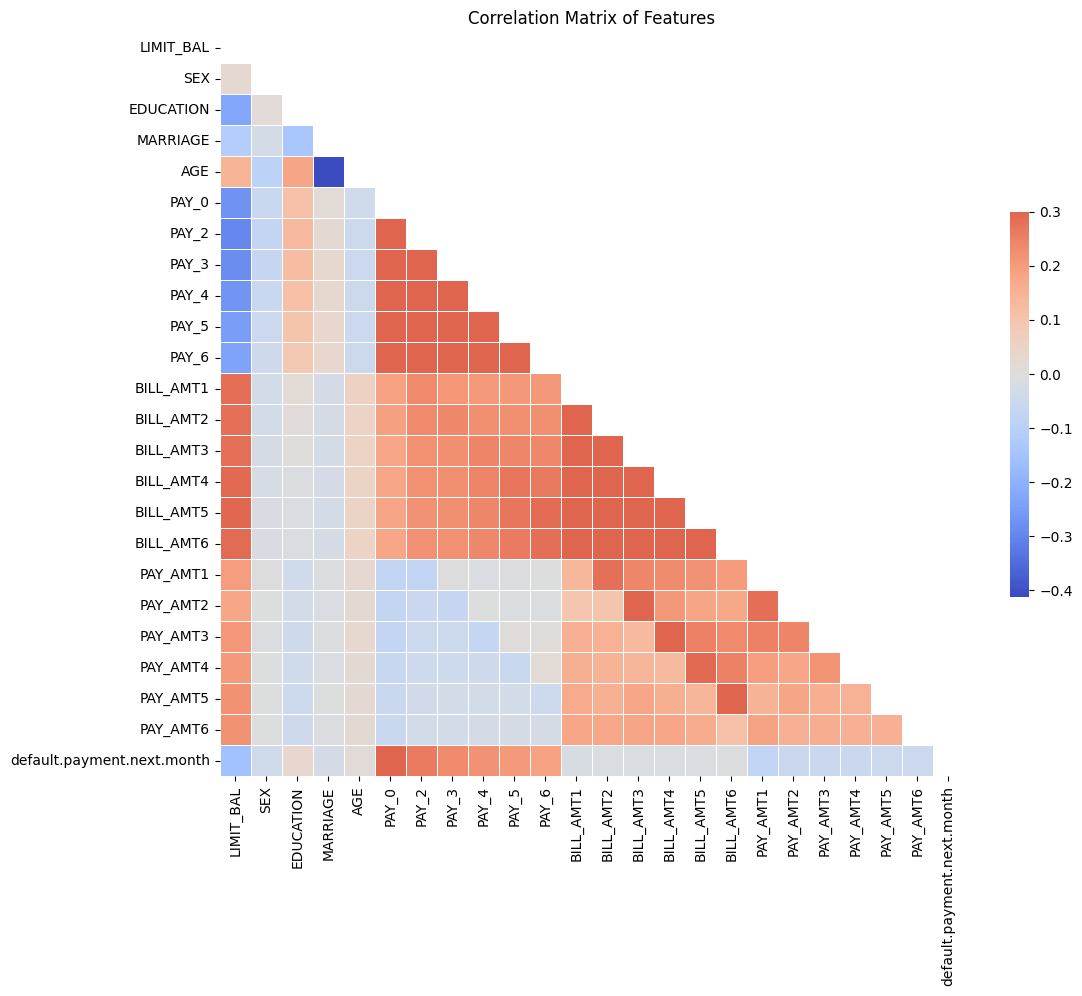

In [16]:
#Heatmap for correlation matrix of all features

plt.figure(figsize=(12, 10))

# Drop non-numeric columns for correlation calculation
df_numeric = df.drop(columns=['SEX_label'], errors='ignore')

#Calc the correlation matrix
corr = df_numeric.corr()

#Show a half (triangle)
mask = np.triu(np.ones_like(corr, dtype=bool))

#Draw heatmap
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix of Features")
plt.show()

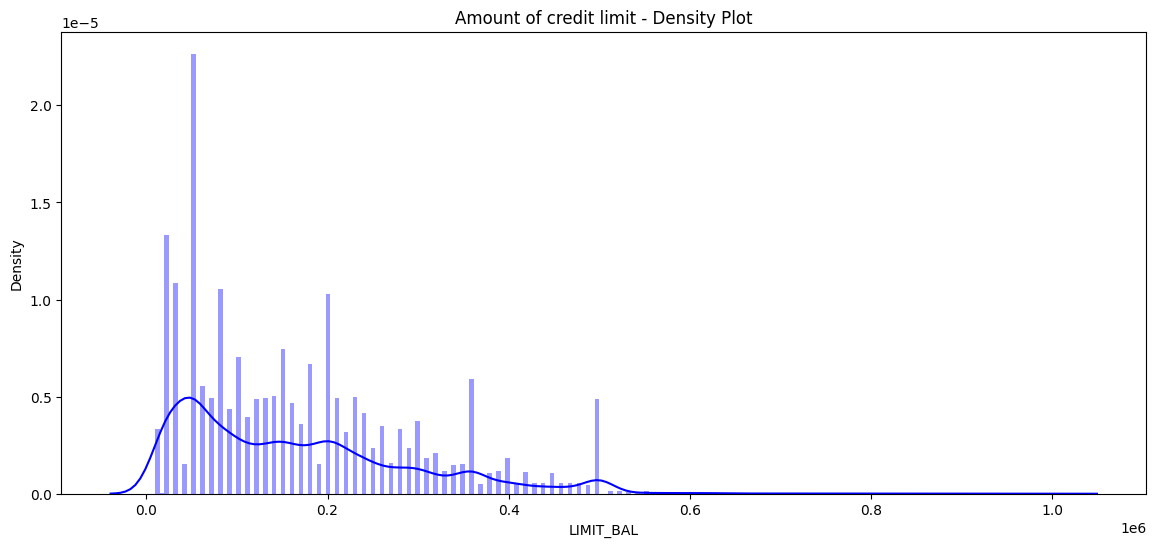

In [17]:
#Distribution of Credit Limit
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

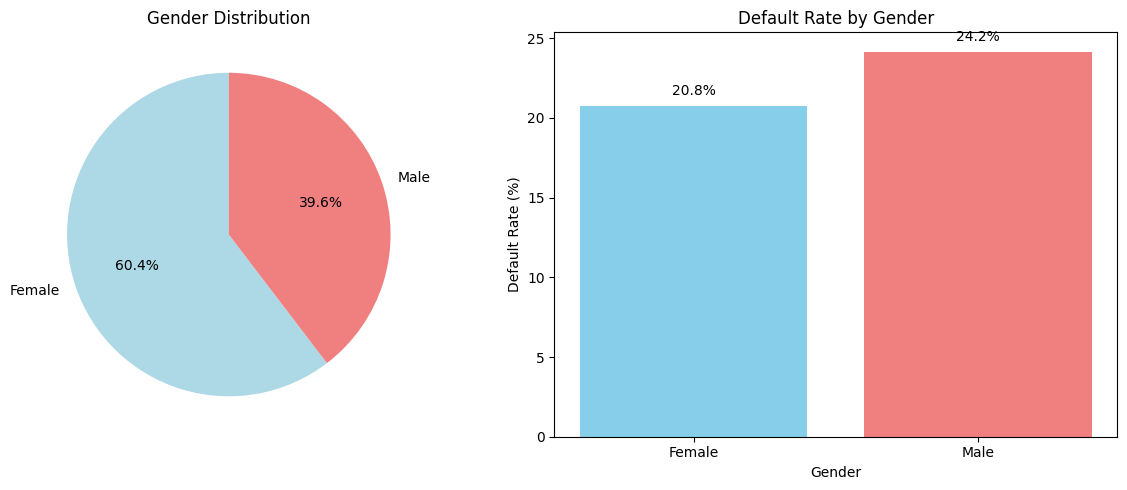

In [18]:
#Gender
sex_labels = {1: 'Male', 2: 'Female'}
df['SEX_label'] = df['SEX'].map(sex_labels)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1:
gender_counts = df['SEX_label'].value_counts()
axes[0].pie(gender_counts.values, labels=gender_counts.index,
            autopct='%1.1f%%', colors=['lightblue', 'lightcoral'], startangle=90)
axes[0].set_title('Gender Distribution')

# Subplot 2:
default_rate = df.groupby('SEX_label')['default.payment.next.month'].mean() * 100
bars = axes[1].bar(default_rate.index, default_rate.values,
                   color=['skyblue', 'lightcoral'])
axes[1].set_title('Default Rate by Gender')
axes[1].set_ylabel('Default Rate (%)')
axes[1].set_xlabel('Gender')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

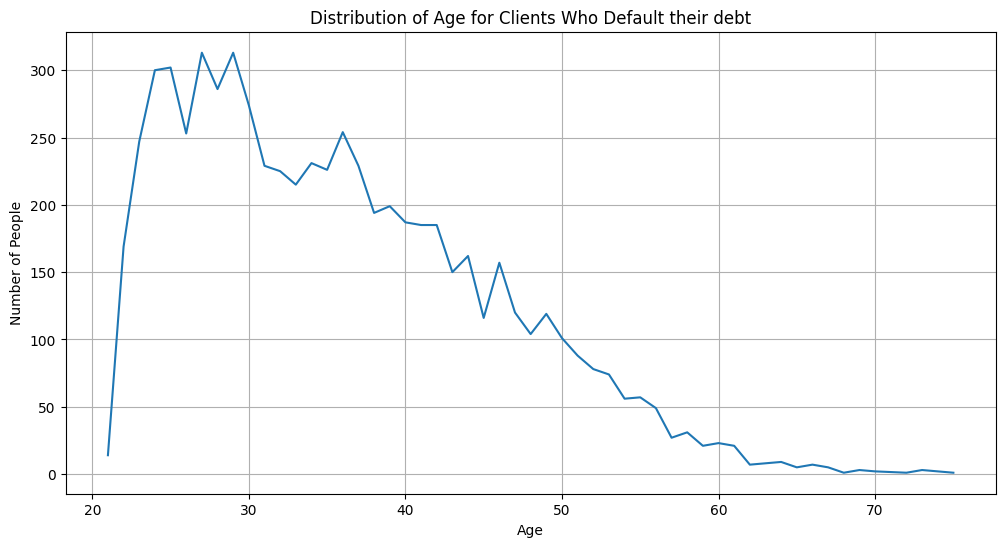

In [19]:
df_paid_on_time = df[df['default.payment.next.month'] == 1]
age_distribution_paid_on_time = df_paid_on_time['AGE'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=age_distribution_paid_on_time.index, y=age_distribution_paid_on_time.values)
plt.title('Distribution of Age for Clients Who Default their debt')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()

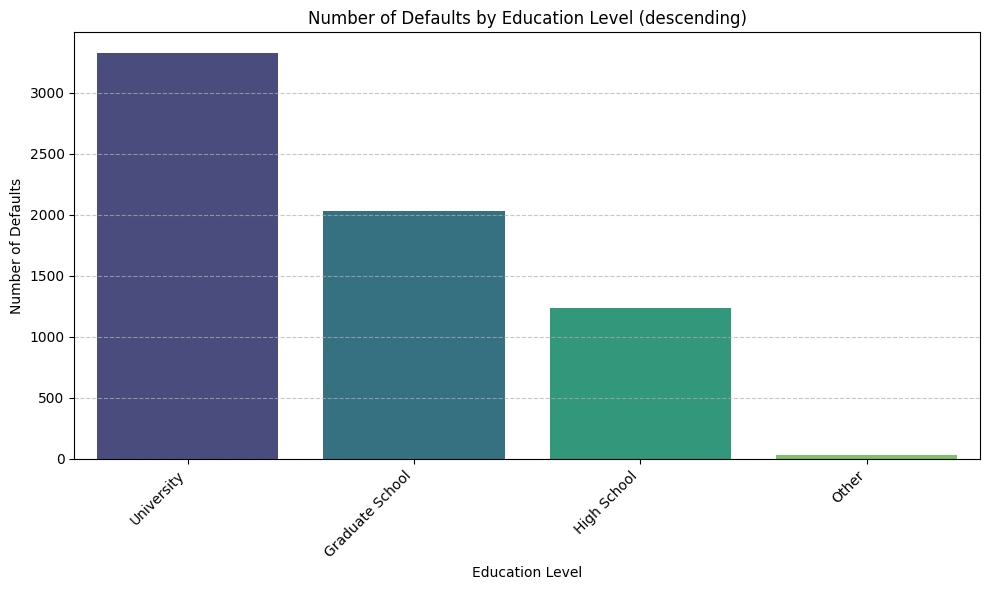

In [20]:
df_defaulters = df[df['default.payment.next.month'] == 1]

education_default_counts = df_defaulters['EDUCATION'].value_counts()

#Map education values to descriptive labels
education_mapping = {
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Other'
}

education_default_counts = education_default_counts.rename(index=education_mapping)

#Get current order and reorder to place 'Other' at the end
current_order = education_default_counts.index.tolist()
if 'Other' in current_order:
    current_order.remove('Other')
    current_order.append('Other')

plt.figure(figsize=(10, 6))
sns.barplot(x=education_default_counts.index, y=education_default_counts.values, palette='viridis', order=current_order)
plt.title('Number of Defaults by Education Level (descending)')
plt.xlabel('Education Level')
plt.ylabel('Number of Defaults')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

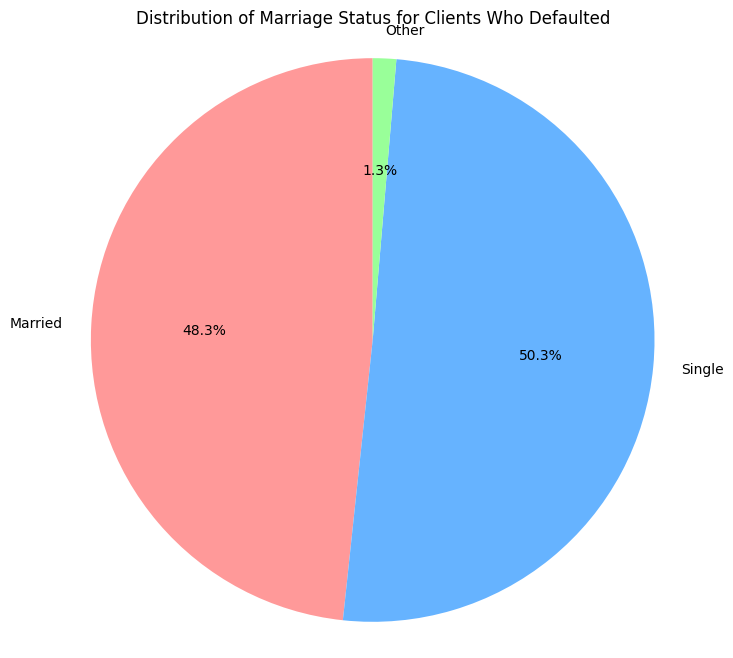

In [21]:
df_defaulters_marriage = df_defaulters['MARRIAGE'].value_counts()

# Merge '0' into '3' (Other) by renaming index and summing
df_defaulters_marriage = df_defaulters_marriage.rename(index={0: 3}).groupby(level=0).sum()

# Map marriage values to labels
marriage_mapping = {1: 'Married', 2: 'Single', 3: 'Other'}
defaulters_marriage_labels = df_defaulters_marriage.index.map(marriage_mapping)

plt.figure(figsize=(8, 8))
plt.pie(df_defaulters_marriage, labels=defaulters_marriage_labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Marriage Status for Clients Who Defaulted')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

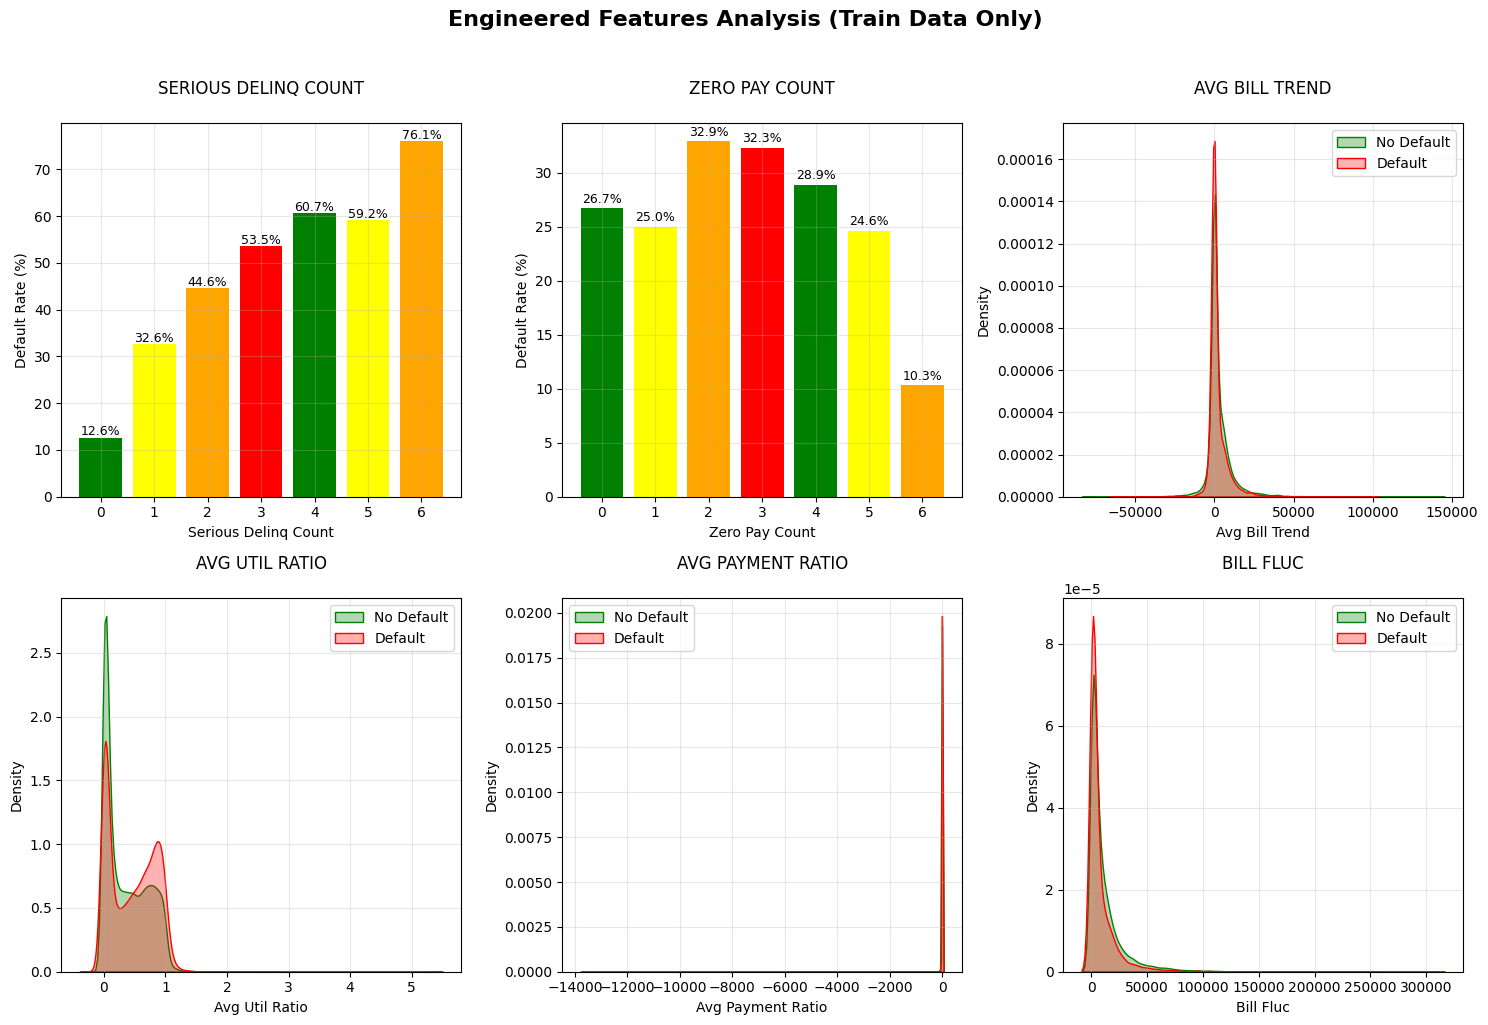

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Engineered Features Analysis (Train Data Only)', fontsize=16, y=1.02, fontweight='bold')

# 1. Bar chart for SQC and ZPC
for idx, feature in enumerate(['SERIOUS_DELINQ_COUNT', 'ZERO PAY COUNT']):
    ax = axes[0, idx]
    default_rate = df_features.groupby(feature)['default'].mean() * 100
    bars = ax.bar(default_rate.index, default_rate.values,
                  color=['green', 'yellow', 'orange', 'red'][:len(default_rate)])
    ax.set_title(f'{feature.replace("_", " ")}\n', fontsize=12)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Default Rate (%)')
    ax.grid(True, alpha=0.3)

    #Add values
    for i, v in enumerate(default_rate.values):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)

# 2. Histogram + KDE for continuous features
continuous_features = ['AVG_UTIL_RATIO', 'AVG_PAYMENT_RATIO',
                       'AVG_BILL_TREND', 'BILL_FLUC']

for idx, feature in enumerate(continuous_features):
    ax = axes[1, idx] if idx < 2 else axes[0, 2] if idx == 2 else axes[1, 2]

    # Split data according to default status
    data_default = df_features[df_features['default'] == 1][feature]
    data_no_default = df_features[df_features['default'] == 0][feature]

    # Plot KDE
    sns.kdeplot(data=data_no_default, ax=ax, label='No Default',
                color='green', fill=True, alpha=0.3)
    sns.kdeplot(data=data_default, ax=ax, label='Default',
                color='red', fill=True, alpha=0.3)

    ax.set_title(f'{feature.replace("_", " ")}\n', fontsize=12)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4.2 Summary of EDA Insights



Imbalanced Data: The dataset shows a significant imbalance between defaulters and non-defaulters. I might need to use metrics like Recall or F1-score rather than Accuracy.


Correlations: Features like `PAY_0`, `PAY_2` show strong correlation with the target variable, suggesting they will be important predictors.


Now I will proceed to build baseline models and then optimize the best performer.


# Step 5: Model Building and Evaluation

## 5.1 Training model

I will test three different algorithms to establish a baseline: Log Regression, Random Forest, XGBoost

Let's see the initial result of training model

In [24]:
models = {'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
          'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
          'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())}

results = []
for name, model in models.items():
    pipeline = ImbPipeline([('features', FeatureEngineer()),
                            ('scaler', StandardScaler()),
                            ('smote', SMOTE(random_state=42)),
                            ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results.append({'Model': name,
                    'AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]),
                    'F1': f1_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Accuracy': accuracy_score(y_test, y_pred)})

# Display
results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print(results_df.round(4).to_string(index=False))

              Model    AUC     F1  Recall  Precision  Accuracy
Logistic Regression 0.7516 0.5182  0.5750     0.4716    0.7635
      Random Forest 0.7514 0.4964  0.4642     0.5333    0.7917
            XGBoost 0.7391 0.4779  0.6488     0.3783    0.6865





















## 5.2 Hyperparameter tuning

In this step, I prioritize AUC as the scoring metric cuz it is excellent for imbalanced datasets. It measures the model's ability to distinguish between classes (Defaulter vs Non-defaulter) across all possible classification thresholds.

I aim to maximize the AUC score to ensure the model has the best possible ranking power before I manually select a decision threshold in the next steps.

I will choose Random Forest and XGBoost to optimize their results because LR is more sensitive with outliers. But I still need it for the comparison with those 2 models

In [25]:
#Create pipeline
pipeline_rf = ImbPipeline([('features', FeatureEngineer()),
                           ('scaler', StandardScaler()),
                           ('smote', SMOTE(random_state=42)),
                           ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))])

# 2.Set up parameter
param_dist_rf = {'model__n_estimators': randint(50, 200),
                 'model__max_depth': randint(5, 20),
                 'model__min_samples_split': randint(2, 20),
                 'model__min_samples_leaf': randint(1, 10),
                 'model__max_features': ['sqrt', 'log2']}

#Run RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=pipeline_rf,
                                      param_distributions=param_dist_rf,
                                      n_iter=10,
                                      scoring='roc_auc',
                                      cv=StratifiedKFold(n_splits=3),
                                      n_jobs=-1,
                                      verbose=1,
                                      random_state=42)

#fit in train set
random_search_rf.fit(X_train, y_train)

#Print result
print(f"\n AUC Score: {random_search_rf.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

 AUC Score: 0.7802




So our AUC Score of Random Forest model increase about 3%




Next is XGBoost

In [26]:
# Calculate the scale_pos_weight ratio for class imbalance
ratio = (y_train == 0).sum() / (y_train == 1).sum()

pipeline_xgb = ImbPipeline([('features', FeatureEngineer()),
                                ('scaler', StandardScaler()),
                                ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=ratio))])

#Set up parameter
param_dist_xgb = {'model__n_estimators': randint(100, 300),
                  'model__learning_rate': uniform(0.01, 0.2),
                  'model__max_depth': randint(3, 8),
                  'model__subsample': uniform(0.7, 0.3),
                  'model__colsample_bytree': uniform(0.7, 0.3),
                  'model__gamma': uniform(0, 0.5)}

#Run RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(pipeline_xgb,
                                       param_distributions=param_dist_xgb,
                                       n_iter=10,
                                       cv=3,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       random_state=42,
                                       verbose=1)

#Fit in train set
random_search_xgb.fit(X_train, y_train)

print(f"\n AUC Score: {random_search_xgb.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 AUC Score: 0.7837


## 5.3 Threshold tuning

Optimal threshold: 0.5174
F1-Score: 0.5421
Recall:   0.5870
Precision: 0.5036
Accuracy: 0.7807


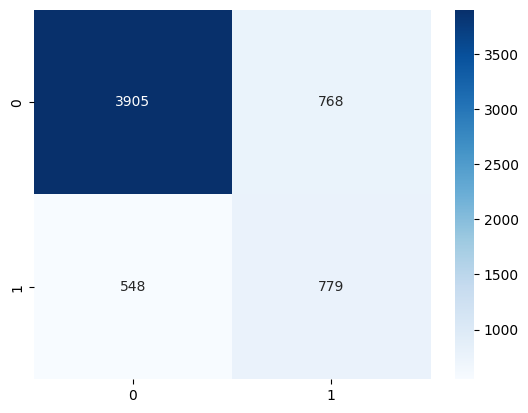

In [27]:
#Find optimal threshold of RF model
final_model = random_search_rf.best_estimator_
y_probs = final_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold: {best_threshold:.4f}")

#assessment
y_pred_new = (y_probs >= best_threshold).astype(int)

print(f"F1-Score: {f1_score(y_test, y_pred_new):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_new):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_new):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_new):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

Recall is too low, I will apply Threshold moving by decrease it down to 0.3 to be more efficient in detecting default clients

In [28]:
best_rf = random_search_rf.best_estimator_

y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

#Try with threshold = 0.3
threshold_new = 0.3
y_pred_new_rf = (y_proba_rf >= threshold_new).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new_rf, digits = 4))

Confusion Matrix:
[[2056 2617]
 [ 181 1146]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9191    0.4400    0.5951      4673
           1     0.3045    0.8636    0.4503      1327

    accuracy                         0.5337      6000
   macro avg     0.6118    0.6518    0.5227      6000
weighted avg     0.7832    0.5337    0.5631      6000



Recall = 0.86 (86%) means that: Out of 100 people who actually defaulted, his model caught 86. This is a very safe number for banks to avoid bad debt.

However, this is a trade-off result, in which there are 2617 False Positive means that we refuse to grant loans to 2617 good customers due to suspicions of default, then the bank will lose interest income from this group.

The model is currently a bit negative, I will slightlt increase threshold to balance 2 benefits.

In [29]:
threshold_new = 0.4
y_pred_new_rf = (y_proba_rf >= threshold_new).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new_rf, digits = 4))

Confusion Matrix:
[[3048 1625]
 [ 360  967]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8944    0.6523    0.7544      4673
           1     0.3731    0.7287    0.4935      1327

    accuracy                         0.6692      6000
   macro avg     0.6337    0.6905    0.6239      6000
weighted avg     0.7791    0.6692    0.6967      6000



Ok now the RF model is more balancing, I will try to improve XGBoost

In [30]:
#Set threshold = 0.4
best_xgb_model = random_search_xgb.best_estimator_
y_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred_best_xgb = (y_proba_best_xgb >= 0.4).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb, digits = 4))

Confusion Matrix:
[[3177 1496]
 [ 370  957]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8957    0.6799    0.7730      4673
           1     0.3901    0.7212    0.5063      1327

    accuracy                         0.6890      6000
   macro avg     0.6429    0.7005    0.6397      6000
weighted avg     0.7839    0.6890    0.7140      6000



Before choosing XGBoost as the most efficient model, I will check F2-score, which 2-time prioritizes Recall than Precision, to ensure which model is better

In [44]:
from sklearn.metrics import fbeta_score

f2_rf = fbeta_score(y_test, y_pred_new_rf, beta=2)
f2_xgb = fbeta_score(y_test, y_pred_best_xgb, beta=2)

print(f"F2 Score of Random Forest: {f2_rf:.4f}")
print(f"F2 Score of XGBoost: {f2_xgb:.4f}")

F2 Score of Random Forest: 0.6120
F2 Score of XGBoost: 0.6165


Clearly XGBoost

# Step 6: Conclusion

## 6.1 Key Drivers of Default

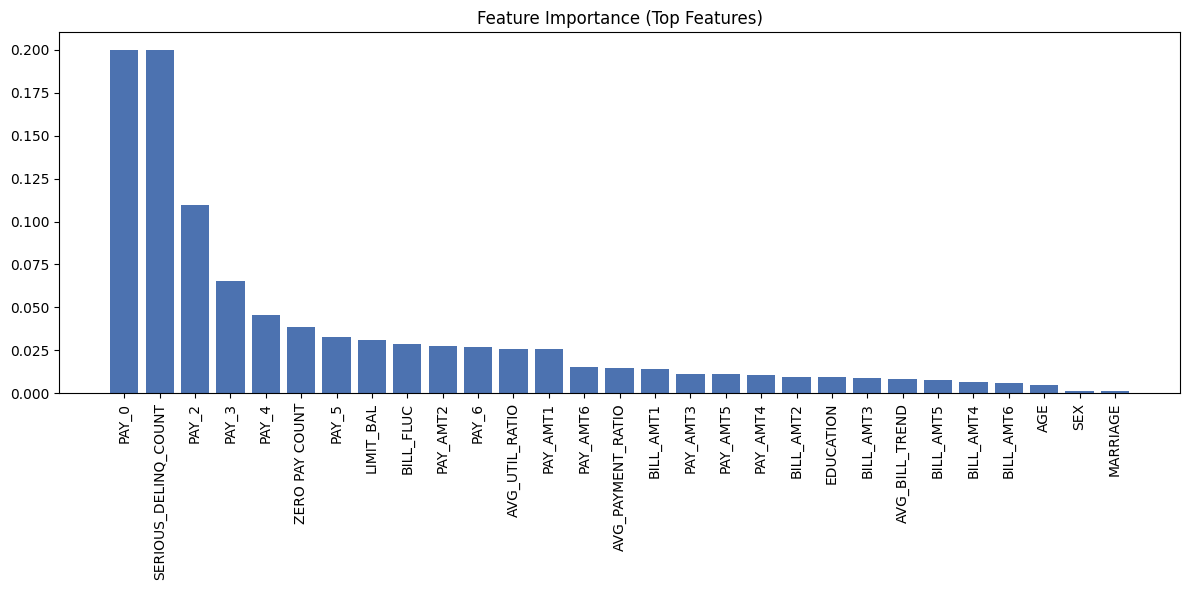

In [31]:
final_model = random_search_rf.best_estimator_

#Visualize chart showing most important features
temp_fe = FeatureEngineer()
temp_X = temp_fe.transform(X_train.iloc[:5])
feature_names = temp_X.columns

importances = final_model.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Top Features)")
plt.bar(range(len(importances)), importances[indices], align="center", color='#4c72b0')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


Of all engineered features, Serious delinquency count plays the most important role

## 6.2 Final Conclusion

After evaluating multiple models (Logistic Regression, Random Forest, XGBoost) and performing hyperparameter tuning, I concluded that XGBoost is the most effective model for this credit scoring problem.



## 6.3 Business Insights & Trade-offs

The high Recall score indicates that the model is highly effective at identifying potential defaulters, significantly reducing the risk of "bad debt" for the bank.


To achieve high safety, the model generates a considerable number of False Positives (predicting good customers as risky). This means the bank might refuse loans to some creditworthy clients, leading to a loss in potential interest income.


For a conservative bank strategy (minimizing loss), this model is suitable. If the bank wants to expand market share aggressively, I might need to increase the threshold (accepting more risk to get more customers).